# Data Analysis Interview Challenge

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


## Load Data

In [11]:
logins = pd.read_json('logins.json')

logins.head()


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [12]:
logins.shape

(93142, 1)

## Part 1 ‐ Exploratory data analysis

- Aggregate these login counts based on 15minute time intervals
- visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.
-  report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [17]:
logins['login_time']

0       1970-01-01 20:13:18
1       1970-01-01 20:16:10
2       1970-01-01 20:16:37
3       1970-01-01 20:16:36
4       1970-01-01 20:26:21
                ...        
93137   1970-04-13 18:50:19
93138   1970-04-13 18:43:56
93139   1970-04-13 18:54:02
93140   1970-04-13 18:57:38
93141   1970-04-13 18:54:23
Name: login_time, Length: 93142, dtype: datetime64[ns]

In [18]:
logins["login_time"] = pd.to_datetime(logins["login_time"], errors="coerce")

print("Total rows:", len(logins))
print("Missing timestamps:", logins["login_time"].isna().sum())
print("Time range:", logins["login_time"].min(), "→", logins["login_time"].max())

logins = logins.dropna(subset=["login_time"]).sort_values("login_time")


Total rows: 93142
Missing timestamps: 0
Time range: 1970-01-01 20:12:16 → 1970-04-13 18:57:38


In [19]:
logins.head()

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


In [20]:
logins_15min = (
    logins
    .set_index("login_time")
    .resample("15T")
    .size()
)

logins_15min.name = "login_count"
logins_15min.head()


/var/folders/pp/_9g9bqld5wb47ph0cdnwm7_r0000gn/T/ipykernel_58472/3295950872.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("15T")


login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15min, Name: login_count, dtype: int64

In [22]:
type(logins_15min)

pandas.core.series.Series

In [23]:
logins_15min.describe()


count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: login_count, dtype: float64

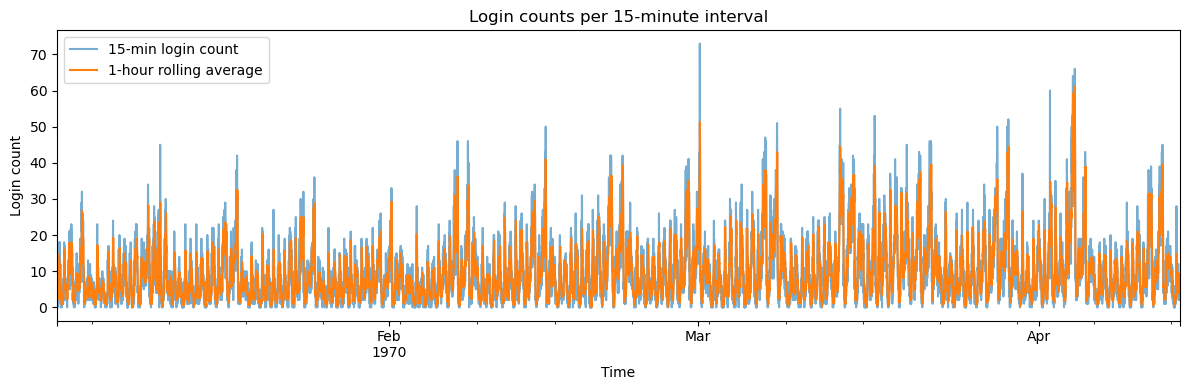

In [32]:
plt.figure(figsize=(12,4))
logins_15min.plot(alpha=0.6, label="15-min login count")
logins_15min.rolling(4).mean().plot(label="1-hour rolling average")
plt.legend()
plt.title("Login counts per 15-minute interval")
plt.xlabel("Time")
plt.ylabel("Login count")
plt.tight_layout()
plt.show()


The blue line shows raw login counts per 15-minute interval, which is highly variable due to short-term randomness. The orange line is a 1-hour rolling average that smooths this noise and makes the underlying temporal structure and periodic demand patterns easier to see.

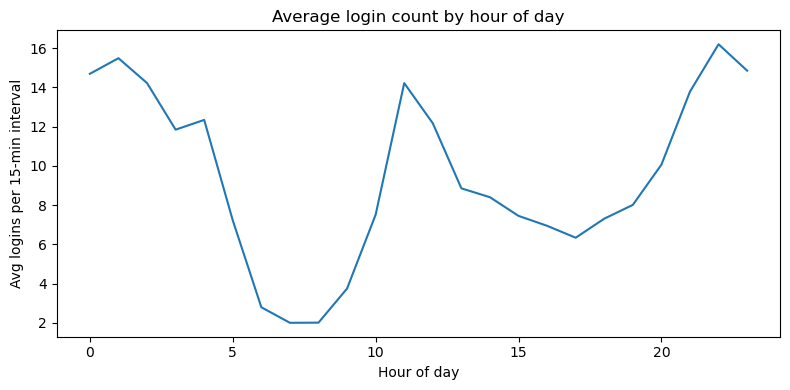

login_time
0     14.688725
1     15.482843
2     14.215686
3     11.840686
4     12.338235
5      7.218137
6      2.789216
7      1.997549
8      2.004902
9      3.742647
10     7.509804
11    14.213235
12    12.166667
13     8.850490
14     8.397059
15     7.446078
16     6.941176
17     6.333333
18     7.303922
19     8.007426
20    10.056373
21    13.781863
22    16.193627
23    14.848039
Name: login_count, dtype: float64

In [27]:
hourly_pattern = logins_15min.groupby(logins_15min.index.hour).mean()

plt.figure(figsize=(8,4))
hourly_pattern.plot()
plt.title("Average login count by hour of day")
plt.xlabel("Hour of day")
plt.ylabel("Avg logins per 15-min interval")
plt.tight_layout()
plt.show()

hourly_pattern


This plot shows the average login count per 15-minute interval as a function of hour of day,
aggregated across the entire dataset. A strong circadian pattern is evident: login activity is
lowest during early morning hours (approximately 6–8am), rises sharply through late morning
with a local peak around midday, declines slightly in the afternoon, and reaches its highest
levels during the evening and late-night hours (around 9–11pm). This indicates that user demand
is highly time-of-day dependent and follows a consistent daily rhythm.


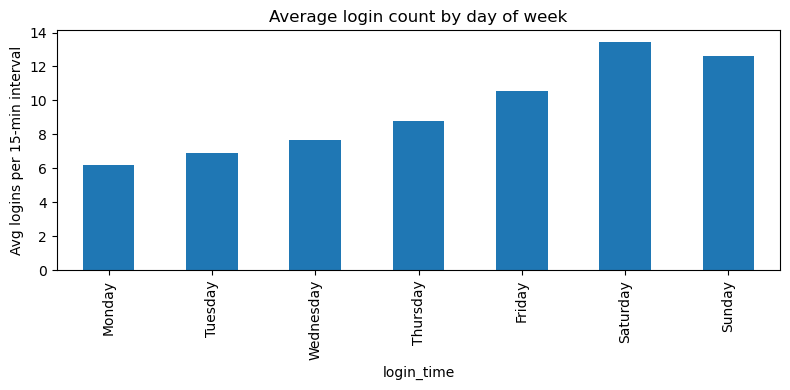

login_time
Monday        6.213380
Tuesday       6.895833
Wednesday     7.692708
Thursday      8.794118
Friday       10.561111
Saturday     13.456250
Sunday       12.615972
Name: login_count, dtype: float64

In [28]:
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow_pattern = (
    logins_15min
    .groupby(logins_15min.index.day_name())
    .mean()
    .reindex(dow_order)
)

plt.figure(figsize=(8,4))
dow_pattern.plot(kind="bar")
plt.title("Average login count by day of week")
plt.ylabel("Avg logins per 15-min interval")
plt.tight_layout()
plt.show()

dow_pattern


This bar chart shows the average login count per 15-minute interval grouped by day of week.
Login activity increases steadily from Monday through Friday and peaks on the weekend,
with Saturday exhibiting the highest average demand and Sunday remaining elevated.
This indicates a clear weekly pattern in user behavior, with substantially higher usage
on weekends compared to weekdays. Such weekly seasonality suggests that demand forecasting
and operational planning should account for both weekday and weekend dynamics.


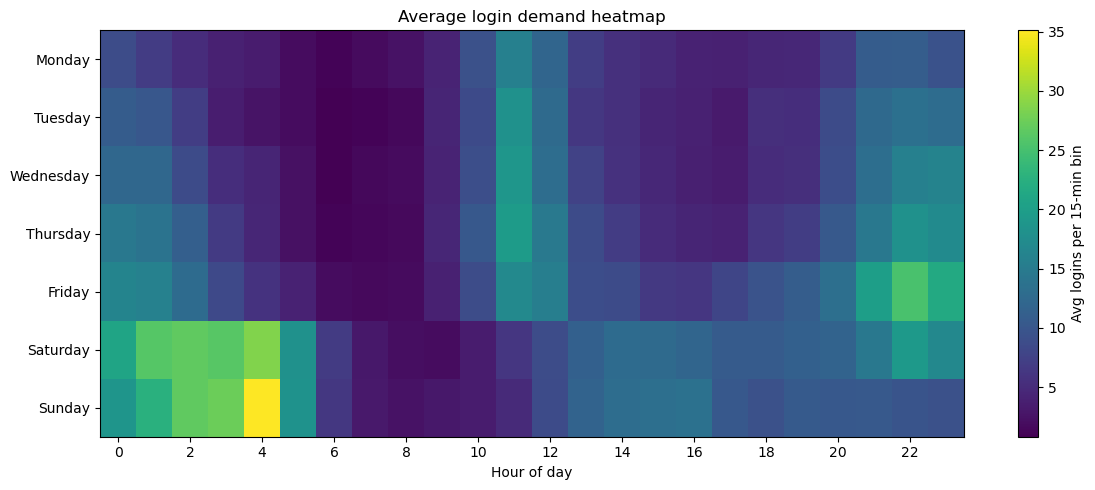

In [29]:
tmp = logins_15min.to_frame()
tmp["day"] = tmp.index.day_name()
tmp["hour"] = tmp.index.hour

heatmap = (
    tmp
    .pivot_table(index="day", columns="hour", values="login_count", aggfunc="mean")
    .reindex(dow_order)
)

plt.figure(figsize=(12,5))
plt.imshow(heatmap, aspect="auto")
plt.colorbar(label="Avg logins per 15-min bin")
plt.yticks(range(len(heatmap.index)), heatmap.index)
plt.xticks(range(0,24,2), list(range(0,24,2)))
plt.xlabel("Hour of day")
plt.title("Average login demand heatmap")
plt.tight_layout()
plt.show()


This heatmap visualizes average login demand as a function of both day of week and hour of day.
Each cell represents the mean number of logins per 15-minute interval, averaged across the
entire dataset. Clear temporal structure is visible: login activity is consistently low during
early morning hours across all days, rises during late morning on weekdays, and reaches its
highest levels during late-night and early-morning hours on weekends. In particular, weekend
nights exhibit substantially higher demand than weekdays, indicating strong interaction
between daily and weekly usage patterns. This highlights the importance of modeling demand
with both hour-of-day and day-of-week effects.


In [30]:
logins_15min.sort_values(ascending=False).head(10)


login_time
1970-03-01 04:30:00    73
1970-04-04 05:30:00    66
1970-04-04 01:30:00    64
1970-04-04 01:15:00    63
1970-04-01 23:30:00    60
1970-04-04 05:00:00    60
1970-04-04 04:45:00    59
1970-04-04 05:15:00    59
1970-04-04 01:45:00    56
1970-03-13 22:15:00    55
Name: login_count, dtype: int64

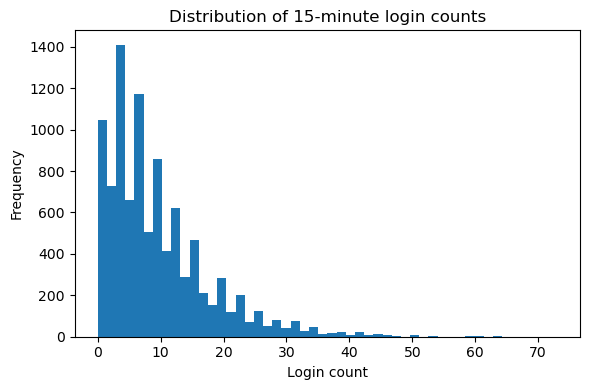

In [31]:
plt.figure(figsize=(6,4))
plt.hist(logins_15min, bins=50)
plt.title("Distribution of 15-minute login counts")
plt.xlabel("Login count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


This histogram shows the distribution of login counts across all 15-minute intervals.
The distribution is strongly right-skewed: most intervals have relatively low login
counts, while a small number of intervals exhibit very high activity. This indicates
that login demand is highly variable and bursty, with occasional extreme spikes. Such
skewness explains the noisiness observed in the raw time series and motivates the use
of temporal aggregation and smoothing when characterizing demand patterns.


## Part 2 ‐ Experiment and metrics design

Goal of this section:
1) Define a **key measure of success**
2) Design a **practical experiment** to evaluate the change (implementation + statistics + interpretation)

## Key Measure of Success

### Primary metric (success definition)
**Cross-city participation rate (driver-level):**
> The fraction of active drivers who complete at least one trip in **both** Gotham and Metropolis during a fixed time window (e.g., per week).

Formally (weekly):
- For each driver *d*, define:
  - `cross_city_d = 1` if driver completed ≥1 trip in Gotham AND ≥1 trip in Metropolis during the week
  - otherwise `cross_city_d = 0`
- Metric = mean(`cross_city_d`) over all active drivers in that week

### Why this is the right metric
- It directly measures the intended behavior change: **drivers serving both cities**, not just more driving overall.
- It is less confounded by demand swings than total trips (a surge in one city could raise total trips without increasing cross-city behavior).
- It is interpretable and operational: managers can track it over time and set targets.

### Secondary / guardrail metrics (to avoid “winning the metric, losing the business”)
We also monitor rider and marketplace health:
- **Rider experience:** pickup ETA, cancellation rate, trip completion rate
- **Marketplace efficiency:** surge frequency / price multiplier, unfulfilled requests
- **Driver outcomes:** earnings per hour, utilization (time on trip / time online), driver satisfaction/churn

The reimbursement should improve cross-city supply **without** degrading rider service in either city or harming driver economics.


## Practical Experiment Design

### Implementation

**Unit of randomization:** driver partner (preferred).
- Randomly assign eligible drivers into:
  - **Treatment:** toll reimbursement enabled automatically for any bridge crossing (two-way)
  - **Control:** no reimbursement (status quo)

**Eligibility criteria (reduce noise):**
- Include only drivers active in a pre-period (e.g., ≥X trips in last 2–4 weeks) to avoid inactive accounts diluting signal.

**Experiment duration:**
- Run for at least **2–4 weeks** to cover weekday/weekend patterns and reduce variance.

**Details:**
- Reimbursement should be automatic (no manual receipt submission) to avoid selection bias from differing effort.
- Track city of each trip (pickup city / drop-off city), and bridge crossings (or inferred via trip geography).
- Ensure driver assignment is fixed for the experiment (no switching arms).

**Why driver-level A/B is appropriate:**
- The treatment changes *driver incentives*; drivers are the decision-makers about crossing.
- It gives clean measurement of behavioral change relative to baseline.

**Potential interference note:**
- In marketplace experiments, one group’s behavior can affect the other (spillover).
- We will monitor this and, if needed, consider a cluster design (e.g., randomize by “home city cohort” or by onboarding cohort).


### Statistical tests

Because the primary metric is binary at the driver-week level (cross-city vs not), we can use:

**Option 1 — Two-proportion z-test (simple)**
- Compare treatment vs control cross-city participation rates:
  - H0: p_treat = p_control
  - H1: p_treat > p_control (one-sided, since we expect an increase)

**Option 2 — Logistic regression (recommended)**
Model:
- `cross_city ~ treatment + baseline_activity + home_city + weekday/weekend mix + ...`
Benefits:
- Adjusts for baseline differences and improves precision
- Allows heterogeneity analysis (e.g., effect differs for drivers near the bridge vs far)

**If repeated weekly measures per driver:**
- Use cluster-robust standard errors at the driver level, or a mixed-effects logistic model.

**Guardrails:**
- For continuous metrics (ETA, earnings/hour): t-test or regression with robust SE
- For rates (cancellation): proportion tests or logistic regression
- Correct for multiple comparisons for guardrails (e.g., focus on directional consistency + practical significance rather than p-values alone)


### Interpreting results + recommendations


**Primary decision rule:**
- The experiment is successful if:
  1) Cross-city participation rate increases materially in treatment vs control
  2) Rider/marketplace guardrails do not degrade beyond acceptable thresholds
  3) The economics make sense (incremental revenue or service improvement justifies toll cost)

**Example interpretations:**
- **Positive & significant increase + stable guardrails:**
  - Recommend rollout, possibly staged (start with peak mismatch hours).
- **Increase in cross-city participation but guardrails worsen (e.g., ETA rises in one city):**
  - Recommend a constrained policy:
    - reimburse only during specific hours (e.g., weekday nights to Gotham, weekday days to Metropolis)
    - cap reimbursements per day/week
    - combine with dynamic prompts to target supply gaps instead of indiscriminate crossings
- **No significant effect:**
  - Toll may not be the binding constraint; drivers may avoid crossing due to familiarity, expected earnings, or safety.
  - Recommend follow-up tests: guaranteed earnings for cross-city trips, targeted bonuses, improved navigation/education, or “return-trip” incentives.

**Key caveats:**
- **Spillover/interference:** marketplace equilibrium changes could affect both groups.
- **Seasonality:** holidays, events, weather could bias the results if not balanced.
- **Heterogeneous effects:** impacts may differ by driver location, tenure, or typical schedule.
- **Cost accounting:** reimbursement cost must be compared against incremental trips, revenue, and service quality improvements.


####  Why this experiment aligns with the city rhythms

Because Gotham is night-peaked and Metropolis is day-peaked on weekdays, cross-city supply flexibility should:
- Reduce unmet demand during peak mismatch hours
- Improve utilization by letting drivers “follow the demand curve”
- Potentially reduce surge/cancellations by smoothing supply across cities

Therefore, a strong analysis would also segment results by:
- weekday vs weekend
- day vs night
- direction of crossing (Gotham→Metropolis vs Metropolis→Gotham)


## Part 3 ‐ Predictive modeling

Goals:
1) Clean + explore the dataset and report the fraction retained
2) Build a predictive model for retention and evaluate performance
3) Translate insights into operational actions to improve retention

In [48]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

df = pd.read_json("ultimate_data_challenge.json")
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [49]:
df.shape, df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


((50000, 12), None)

### Label definition: retained

The prompt states that data was pulled "several months later" and users are considered retained if active in the preceding 30 days.
A common robust approach (when the exact pull date is not explicitly provided) is to use the **maximum observed `last_trip_date`** as a proxy for the pull date.

- `pull_date = max(last_trip_date)`
- `retained = 1` if `last_trip_date >= pull_date - 30 days`, else 0

After creating the label, we will drop `last_trip_date` from features to avoid leakage.


In [50]:
df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce")
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"], errors="coerce")

print("Missing signup_date:", df["signup_date"].isna().sum())
print("Missing last_trip_date:", df["last_trip_date"].isna().sum())

print("signup_date range:", df["signup_date"].min(), "→", df["signup_date"].max())
print("last_trip_date range:", df["last_trip_date"].min(), "→", df["last_trip_date"].max())


Missing signup_date: 0
Missing last_trip_date: 0
signup_date range: 2014-01-01 00:00:00 → 2014-01-31 00:00:00
last_trip_date range: 2014-01-01 00:00:00 → 2014-07-01 00:00:00


In [45]:
cutoff = pd.Timestamp("2014-06-01")
df["retained"] = (df["last_trip_date"] >= cutoff).astype(int)

df["retained"].value_counts(), df["retained"].value_counts(normalize=True)


(retained
 0    50000
 Name: count, dtype: int64,
 retained
 0    1.0
 Name: proportion, dtype: float64)

In [41]:
df.describe(include="all").T


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
city,50000,3,Winterfell,23336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trips_in_first_30_days,50000.0,NaN,NaN,NaN,2.2782,0.0,0.0,1.0,3.0,125.0,3.792684
signup_date,0,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN
avg_rating_of_driver,41878.0,NaN,NaN,NaN,4.601559,1.0,4.3,4.9,5.0,5.0,0.617338
avg_surge,50000.0,NaN,NaN,NaN,1.074764,1.0,1.0,1.0,1.05,8.0,0.222336
last_trip_date,0,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN
phone,49604,2,iPhone,34582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surge_pct,50000.0,NaN,NaN,NaN,8.849536,0.0,0.0,0.0,8.6,100.0,19.958811
ultimate_black_user,50000,2,False,31146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday_pct,50000.0,NaN,NaN,NaN,60.926084,0.0,33.3,66.7,100.0,100.0,37.081503


#### Q1: Retention fraction

In [51]:
cutoff = pd.Timestamp("2014-06-01")
df["retained"] = (df["last_trip_date"] >= cutoff).astype(int)

df["retained"].value_counts(), df["retained"].value_counts(normalize=True)


(retained
 0    31196
 1    18804
 Name: count, dtype: int64,
 retained
 0    0.62392
 1    0.37608
 Name: proportion, dtype: float64)

In [52]:
num_cols = [
    "avg_dist", "avg_rating_by_driver", "avg_rating_of_driver",
    "surge_pct", "avg_surge", "trips_in_first_30_days", "weekday_pct"
]

df[num_cols].describe()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,surge_pct,avg_surge,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,8.849536,1.074764,2.278200,60.926084
std,5.707357,0.446652,0.617338,19.958811,0.222336,3.792684,37.081503
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,0.000000,1.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,0.000000,1.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,8.600000,1.050000,3.000000,100.000000
max,160.960000,5.000000,5.000000,100.000000,8.000000,125.000000,100.000000


In [53]:
df.groupby("retained")[num_cols].mean()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,surge_pct,avg_surge,trips_in_first_30_days,weekday_pct
retained,,,,,,,
0,6.207939,4.787464,4.607557,8.666739,1.075339,1.658482,60.647032
1,5.114788,4.762772,4.592930,9.152797,1.073809,3.306318,61.389034


### Exploratory insights

A comparison of retained vs non-retained users reveals clear behavioral differences.
The strongest signal is early engagement: retained users complete more than twice as many
trips in their first 30 days (3.3 vs 1.7 on average). Retained users also tend to take
shorter trips, suggesting more frequent, utility-driven usage patterns. Surge exposure
shows modest differences, with retained users experiencing slightly more surge trips but
at similar average surge multipliers. Ratings and weekday usage show relatively small
mean differences and are likely secondary predictors.


### Q2: Modeling

In [54]:
# Define target
y = df["retained"]

# Drop leakage column
X = df.drop(columns=["retained", "last_trip_date"])

# Add simple signup-time features
X["signup_weekday"] = X["signup_date"].dt.weekday
X["signup_month"] = X["signup_date"].dt.month
X = X.drop(columns=["signup_date"])

# Identify feature groups
cat_cols = ["city", "phone"]
bool_cols = ["ultimate_black_user"]
X[bool_cols] = X[bool_cols].astype(int)

num_cols_model = [c for c in X.columns if c not in cat_cols + bool_cols]



preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols_model),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("bool", "passthrough", bool_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((40000, 12), (10000, 12))

### Logistic Regression

In [55]:
log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])

log_reg.fit(X_train, y_train)

p_lr = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression ROC-AUC:", round(roc_auc_score(y_test, p_lr), 4))
print("Logistic Regression PR-AUC:", round(average_precision_score(y_test, p_lr), 4))


Logistic Regression ROC-AUC: 0.7538
Logistic Regression PR-AUC: 0.6578


### Random Forest

In [56]:
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample",
        min_samples_leaf=5,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)

p_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest ROC-AUC:", round(roc_auc_score(y_test, p_rf), 4))
print("Random Forest PR-AUC:", round(average_precision_score(y_test, p_rf), 4))


Random Forest ROC-AUC: 0.8523
Random Forest PR-AUC: 0.785


We first trained a logistic regression model as a transparent baseline, achieving a ROC-AUC
of 0.75 and PR-AUC of 0.66. We then trained a Random Forest model to capture nonlinear
relationships and interactions between features such as early trip frequency, surge exposure,
and usage patterns. The Random Forest substantially improved performance (ROC-AUC = 0.85,
PR-AUC = 0.79), indicating that retention behavior is driven by nonlinear effects beyond what
a linear model can capture. Model performance was evaluated on a held-out test set, suggesting
good generalization within this cohort.


In [57]:
from sklearn.metrics import classification_report, confusion_matrix

pred_rf = (p_rf >= 0.5).astype(int)

print(classification_report(y_test, pred_rf))
confusion_matrix(y_test, pred_rf)


              precision    recall  f1-score   support

           0       0.83      0.81      0.82      6239
           1       0.70      0.73      0.71      3761

    accuracy                           0.78     10000
   macro avg       0.76      0.77      0.77     10000
weighted avg       0.78      0.78      0.78     10000



array([[5056, 1183],
       [1026, 2735]])

#### Predictive modeling approach and validity

We first trained a logistic regression model as an interpretable baseline, which achieved
a ROC-AUC of 0.75 and PR-AUC of 0.66. We then trained a Random Forest model to capture
nonlinear effects and interactions between early engagement, pricing exposure, and usage
patterns. The Random Forest substantially improved performance (ROC-AUC = 0.85, PR-AUC = 0.79),
indicating that rider retention is driven by nonlinear relationships beyond what a linear
model can capture.

Model performance was evaluated on a held-out test set using ROC-AUC and PR-AUC, which are
appropriate metrics given moderate class imbalance. While the model shows strong predictive
power within this cohort, results may vary across different signup cohorts or seasonal
conditions.


### Q3: Feature importance

In [58]:
# Extract feature names after preprocessing
ohe = rf.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(["city", "phone"])

feature_names = np.concatenate([
    num_cols_model,
    cat_feature_names,
    ["ultimate_black_user"]
])

importances = rf.named_steps["clf"].feature_importances_

fi = (
    pd.Series(importances, index=feature_names)
    .sort_values(ascending=False)
)

fi.head(15)


avg_rating_by_driver      0.156393
weekday_pct               0.132928
avg_dist                  0.122658
surge_pct                 0.096835
city_King's Landing       0.090121
avg_surge                 0.073822
trips_in_first_30_days    0.072296
avg_rating_of_driver      0.050993
signup_weekday            0.045411
ultimate_black_user       0.044685
phone_Android             0.035408
phone_iPhone              0.033664
city_Astapor              0.027395
city_Winterfell           0.016930
phone_None                0.000460
dtype: float64

### Operationalizing retention insights

The model highlights several actionable drivers of rider retention. Early engagement is
critical: users who complete more trips in their first 30 days are far more likely to be
retained, suggesting that onboarding incentives and early-use promotions could significantly
improve long-term retention. Trip quality also plays a major role, as reflected by the strong
importance of driver ratings, indicating that improving the rider–driver experience can
directly impact retention.

Usage patterns suggest that riders who integrate Ultimate into weekday routines (e.g.,
commuting) are more likely to remain active, supporting targeted campaigns for habitual use
cases. Pricing experience matters as well: while occasional surge pricing is tolerated, high
or frequent surge exposure may reduce retention, suggesting opportunities for improved surge
messaging or targeted discounts for at-risk users.

Finally, differences by city and premium product usage indicate that retention strategies
should be segmented by geography and user type rather than applying uniform incentives across
the entire user base.


# Overall Summary and Conclusions

This notebook analyzes user demand patterns, designs an experiment to improve cross-city supply, and builds a predictive model to understand and improve rider retention for Ultimate Technologies Inc.

---

## Part 1 — Login Demand Analysis

Using simulated login timestamps aggregated into 15-minute intervals, we analyzed temporal demand patterns.

**Key findings:**
- **Strong daily (circadian) cycle:** Login activity is lowest in the early morning hours and peaks during late morning and late evening.
- **Clear weekly seasonality:** Demand increases steadily from Monday through Friday and peaks on weekends, with Saturday showing the highest average activity.
- **Interaction of day and hour:** A day-of-week × hour-of-day heatmap reveals that weekday demand peaks around midday, while weekend demand is highest during late-night and early-morning hours.
- **High variability and skewness:** The distribution of 15-minute login counts is strongly right-skewed, with most intervals showing low to moderate activity and a small number of extreme spikes.

**Conclusion:** Login demand is highly structured and predictable at daily and weekly timescales, suggesting that operational planning and capacity allocation should explicitly account for time-of-day and day-of-week effects.

---

## Part 2 — Experiment and Metrics Design (Gotham ↔ Metropolis)

To encourage drivers to serve both cities by reimbursing toll costs, we proposed a driver-level randomized experiment.

**Key success metric:**
- **Cross-city participation rate:** the fraction of active drivers completing at least one trip in both cities within a fixed time window (e.g., weekly).
- This metric directly measures the intended behavioral change and is less confounded than total trip volume.

**Experiment design:**
- Randomize eligible drivers into treatment (toll reimbursement) and control groups.
- Run the experiment for multiple weeks to capture weekday/weekend dynamics.
- Evaluate impact using proportion tests or logistic regression, with controls for baseline activity.

**Interpretation framework:**
- A successful experiment increases cross-city participation without harming rider experience (ETA, cancellations) or driver economics (earnings/hour).
- Results should be interpreted with awareness of potential spillovers, seasonality, and heterogeneous effects by time of day or driver segment.

---

## Part 3 — Predictive Modeling of Rider Retention

We analyzed a cohort of users who signed up in January 2014 to predict whether a user would be retained (active in the preceding 30 days as of June 2014).

### Data preparation and EDA
- Retention rate: **~37.6%** of users were retained.
- Strong early engagement signal: retained users completed more than twice as many trips in their first 30 days compared to non-retained users.
- Additional differences were observed in trip distance, surge exposure, and usage patterns.

### Modeling results
We trained two models using a held-out test set:
- **Logistic Regression (baseline):**
  - ROC-AUC ≈ **0.75**
  - PR-AUC ≈ **0.66**
- **Random Forest (nonlinear model):**
  - ROC-AUC ≈ **0.85**
  - PR-AUC ≈ **0.79**

The Random Forest substantially outperformed the baseline, indicating that nonlinear effects and feature interactions play an important role in retention.

### Key predictors
Top drivers of retention included:
- Rider experience quality (e.g., average rating by driver)
- Early engagement (trips in the first 30 days)
- Usage patterns (weekday vs weekend usage, average trip distance)
- Pricing exposure (surge frequency and magnitude)
- City and product segmentation (including premium usage)

### Operational implications
- **Increase early activation:** Encourage new users to complete more trips shortly after signup via onboarding incentives and targeted promotions.
- **Improve trip quality:** Focus on rider–driver experience to improve ratings and reduce friction.
- **Manage surge experience:** Use better messaging or targeted discounts to mitigate negative effects of high surge exposure.
- **Segment retention strategies:** Tailor interventions by city, usage pattern, and product tier rather than applying uniform incentives.

---

## Final Takeaway

Across demand analysis, experimental design, and predictive modeling, the results consistently show that user behavior is highly structured and that early experiences strongly shape long-term outcomes. By aligning operational decisions with temporal demand patterns and leveraging data-driven retention insights, Ultimate can improve marketplace efficiency and long-term rider engagement.
